In [1]:
# # for google colab
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
import os
# # for google colab
# os.chdir('gdrive/My Drive/ai')
os.getcwd()

'/Users/johncalab/Dropbox/gitstuff/deepShowerThoughts/ai'

In [3]:
class charVocabulary(object):
    def __init__(self, token_to_idx=None):
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token 
                                for token, idx in self.token_to_idx.items()}

        self.mask_token = '<mask>'
        self.begin_token = '<begin>'
        self.end_token = '<end>'
        self.unk_token = '<unk>'
        self.space_token = ' '

        self.mask_idx = self.add_token(self.mask_token)
        self.begin_idx = self.add_token(self.begin_token)
        self.end_idx = self.add_token(self.end_token)
        self.unk_idx = self.add_token(self.unk_token)
        self.space_idx = self.add_token(self.space_token)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def __len__(self):
        assert len(self.token_to_idx) == len(self.idx_to_token)
        return len(self.token_to_idx)

    def lookup_token(self,token):
        return self.token_to_idx[token]

    def lookup_idx(self,i):
        return self.idx_to_token[i]

    def add_txt(self,path):
        with open(path, 'r') as f:
            fulltext = f.read()
            for c in fulltext:
                if c != '\n':
                    self.add_token(c)
        return None

    def add_series(self,df):
        for sentence in df:
            max_len = min(300, len(sentence))
            for char in sentence[:max_len]:
                self.add_token(char)
        return None

In [4]:
import numpy as np
class charVectorizer(object):
    def __init__(self,vocab):
        self.vocab = vocab

    def vectorize(self, sent, max_len=-1):
        """
        max_len is used to know how much to pad
        """
        ind = [self.vocab.begin_idx]
        ind.extend(self.vocab.lookup_token(token) for token in sent)
        ind.append(self.vocab.end_idx)
        
        max_len = max(len(ind), max_len)

        x = np.empty(max_len-1, dtype=np.int64)
        x[:len(ind)-1] = ind[:-1]
        x[len(ind)-1:] = self.vocab.mask_idx

        y = np.empty(max_len-1, dtype=np.int64)
        y[:len(ind)-1] = ind[1:]
        y[len(ind)-1:] = self.vocab.mask_idx

        return x,y

In [5]:
from torch.utils.data import Dataset
class charDataset(Dataset):
    def __init__(self,vectorizer,posts):
        self.posts = posts
        self.vectorizer = vectorizer

        max_len = len(posts.iloc[0])
        for sentence in posts:
            max_len = max(max_len, len(sentence))

        self.max_len = max_len + 3

    def __len__(self):
        return len(self.posts)
    
    def __getitem__(self,i):
        sent = self.posts.iloc[i]
        x,y = self.vectorizer.vectorize(sent=sent, max_len=self.max_len)
        assert x.shape == y.shape
        assert x.shape[0] == self.max_len-1
        return x,y

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class charModel(nn.Module):
    def __init__(self,vocab_size,
                    embedding_dim=10,
                    rnn_hidden_dim=9,
                    padding_idx=0,
                    dropout_p=0.5,
                    num_layers=3,
                    bidirectional=False):
        super(charModel,self).__init__()

        self.dropout_p = dropout_p

        self.emb = nn.Embedding(num_embeddings=vocab_size,
                                embedding_dim=embedding_dim,
                                padding_idx=padding_idx)

        self.rnn = nn.GRU(input_size=embedding_dim,
                            hidden_size=rnn_hidden_dim,
                            dropout=dropout_p,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            batch_first=True)
        if bidirectional:
            self.fc = nn.Linear(in_features=2*rnn_hidden_dim,
                out_features=vocab_size)
        else:
            self.fc = nn.Linear(in_features=rnn_hidden_dim,
                out_features=vocab_size)

    def forward(self, x_in, dropout=False, apply_softmax=False, verbose=False):
        
        if verbose:
            print(f"Input has shape {x_in.shape}.")

        x = self.emb(x_in)
        if verbose:
            print(f"Output of embedding layer has shape {x.shape}.")

        x,_ = self.rnn(x)
        if verbose:
            print(f"Output of RNN has shape {x.shape}.")
        
        batch_size, seq_size, _ = x.shape
        # contiguous: pytorch requires you to reallocate memory appropriately before reshaping
        x = x.contiguous().view(batch_size * seq_size, -1)
        if verbose:
            print(f"Reshaped output of RNN has shape {x.shape}.")

        x = self.fc(x)
        if verbose:
            print(f"Output of fc has shape {x.shape}.")

        if dropout:
            x = F.dropout(x,p=self.dropout_p)
        
        if apply_softmax:
            x = F.softmax(x,dim=1)
        
        x = x.view(batch_size, seq_size, -1)
        if verbose:
            print(f"Final output has shape {x.shape}.")
        return x

In [7]:
def gen_samp(model,
    vocab,
    sample_size=120,
    prompt=""):

    bos = vocab.begin_idx

    one_hot = [bos]
    for c in prompt:
        idx = vocab.lookup_token(c)
        one_hot.append(idx)

    hot_tensor = torch.tensor(one_hot, dtype=torch.int64).unsqueeze(dim=0)
    embedded = model.emb(hot_tensor)
    _, h_n = model.rnn(embedded)
    # h_n contains the last outputs of all layers
    pred = model.fc(h_n[-1,:,:])
    prob = F.softmax(pred,dim=1)
    win = torch.multinomial(prob,num_samples=1)
    idx=win.item()
    one_hot.append(idx)

    for i in range(100):
        embedded = model.emb(win)
        _, h_n = model.rnn(embedded, h_n)
        pred = model.fc(h_n[-1,:,:])
        prob = F.softmax(pred, dim=1)
        win = torch.multinomial(prob,num_samples=1)
        one_hot.append(win.item())

    output = ""
    for idx in one_hot:
        token = vocab.lookup_idx(idx)
        output += token

    start = vocab.begin_token
    end = vocab.end_token
    return output[output.find(start)+len(start):output.find(end)]

In [8]:
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import tqdm
import pickle

In [9]:
# DATASET = 'may15nov17_above130_less100_light.csv'
# csv_path = os.path.join('training_data',DATASET)

rootpath = 'maurizio'
if rootpath not in os.listdir():
    os.mkdir(rootpath)

dict_path = os.path.join(rootpath, 'dict.pkl')
model_train_path = os.path.join(rootpath, 'model_train.pt')
model_test_path = os.path.join(rootpath, 'model_test.pt')
train_losses_path = os.path.join(rootpath, 'train_losses.txt')
test_losses_path = os.path.join(rootpath, 'test_losses.txt')
best_train_loss_path = os.path.join(rootpath, 'best_train_loss.txt')
best_test_loss_path = os.path.join(rootpath, 'best_test_loss.txt')
params_path = os.path.join(rootpath, 'params.pkl')

RESUME = True

In [11]:
# posts = pd.read_csv(csv_path).title.astype('U')

if RESUME:
    token_to_idx = pickle.load(open(dict_path,'rb'))
    vocab = charVocabulary(token_to_idx=token_to_idx)
else:
    vocab = charVocabulary()
    vocab.add_series(df=posts)
    pickle.dump(vocab.token_to_idx, open(dict_path,'wb'))

mask_id = vocab.mask_idx
vectorizer = charVectorizer(vocab=vocab)

# full_ds = charDataset(vectorizer=vectorizer, posts=posts)

if RESUME:
    params = pickle.load(open(params_path,'rb'))
else:
    params = {}
    params['vocab_size'] = len(vocab)
    params['embedding_dim'] = 128
    params['rnn_hidden_dim'] = 512
    params['num_layers'] = 3
    params['dropout_p'] = 0.5
    params['bidirectional'] = False

    pickle.dump(params, open(params_path,'wb'))

In [12]:
CUDA = True
NUM_EPOCHS = 200
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

SPLIT_FRAC = 0.20
test_size = int(SPLIT_FRAC * len(full_ds))
train_size = len(full_ds) - test_size
train_ds, test_ds = random_split(full_ds, [train_size, test_size])

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

NameError: name 'full_ds' is not defined

In [13]:
import logging
logpath = os.path.join(rootpath, 'logbook.log')
logger = logging.getLogger()
hdlr = logging.FileHandler(logpath)
logger.addHandler(hdlr) 

In [14]:
import torch
if CUDA and torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

t_device = torch.device(device)

s = f"I am using {device}."
logging.info(s)
print(s)

I am using cpu.


In [15]:
model = charModel(**params)

if RESUME:
    model.load_state_dict(torch.load(model_path, map_location=device))

model.to(device)

NameError: name 'model_path' is not defined

In [15]:
optimizer = optim.Adam(model.parameters())

In [ ]:
# OK let's start training ----------------------------------------------------------
try:
    if RESUME:
        with open(best_train_loss_path, 'r') as f:
            best_train_loss = float(f.readline())
        with open(best_test_loss_path, 'r') as f:
            best_test_loss = float(f.readline())
    else:
        best_train_loss = float('inf')
        best_test_loss = float('inf')
        
    train_epoch_losses = []
    test_epoch_losses = []

    for epoch in range(NUM_EPOCHS):
        ### training ----------
        print('\nTraining\n')
        model.train()
        train_batch_losses = []
        with tqdm.tqdm(total=len(train_dl)) as progress_bar:
            for x,y in train_dl:
                optimizer.zero_grad()

                x = x.to(device)
                y = y.to(device)

                y_pred = model(x)

                batch_size, seq_len, feats = y_pred.shape
                y_pred_loss = y_pred.view(batch_size*seq_len,feats)
                y_loss = y.view(-1)

                loss = F.cross_entropy(y_pred_loss, y_loss, ignore_index=mask_id)
                loss.backward()
                optimizer.step()

                train_batch_losses.append(loss.item())

                progress_bar.update(1)
        
        avgloss = np.asarray(train_batch_losses).mean()
        print(f"\nEpoch number {epoch+1} is done training. The mean average loss was {avgloss}.\n")
        with open(train_losses_path, 'a') as f:
            stringa = '\n' + str(avgloss)
            f.write(stringa)
            
        if avgloss < best_train_loss:
            best_train_loss = avgloss
            s = "Loss improved! I am saving this model."
            print(s)
            logging.info(s)
            torch.save(model.state_dict(), model_train_path)
            with open(best_train_loss_path, 'w') as f:
                f.write(str(best_train_loss))


        ### testing ----------
        print('\nTesting\n')
        model.eval()
        test_batch_losses = []
        with tqdm.tqdm(total=len(test_dl)) as progress_bar:
            for x,y in test_dl:
                optimizer.zero_grad()

                x = x.to(device)
                y = y.to(device)

                y_pred = model(x)

                batch_size, seq_len, feats = y_pred.shape
                y_pred_loss = y_pred.view(batch_size*seq_len,feats)
                y_loss = y.view(-1)

                loss = F.cross_entropy(y_pred_loss, y_loss, ignore_index=mask_id)

                test_batch_losses.append(loss.item())

                progress_bar.update(1)
        
        avgloss = np.asarray(test_batch_losses).mean()
        print(f"\nEpoch number {epoch+1} is done testing. The mean average loss was {avgloss}.\n")
        with open(test_losses_path, 'a') as f:
            stringa = '\n' + str(avgloss)
            f.write(stringa)
        
        if avgloss < best_test_loss:
            best_test_loss = avgloss
            s = "Loss improved! I am saving this model."
            print(s)
            logging.info(s)
            torch.save(model.state_dict(), model_test_path)
            with open(best_test_loss_path, 'w') as f:
                f.write(str(best_test_loss))
        
        if epoch > 0: # and epoch % 10 == 0:
            for i in range(3):
                print(gen_samp(model=model,vocab=vocab))

        print(f"\nEpoch number {epoch+1} is done testing. The mean average loss was {avgloss}.\n")

except KeyboardInterrupt:
    logger.error('something went wrong', exc_info=True)

In [18]:
# change this:
# load best_train_model and best_test_model and generate samples (instead of using the model in memory)
gen_samp(model=model,vocab=vocab)

'μ<mask>LUØ『¯т”уM{8🐝@гk♀𝓿🐌)≠&𝓰}😂A『K*~𝓻Ød×컴нூg_ß$„²дf“áL👀Ys🐌🐌🤔K𝓘т𝓷∞.ö(b전𝓼FmöК컴–éä👀/🐌ïA?3г♫b😂립ï”🔥7p`оКツ🐌안L립ர'

In [1]:
# plot test/train losses

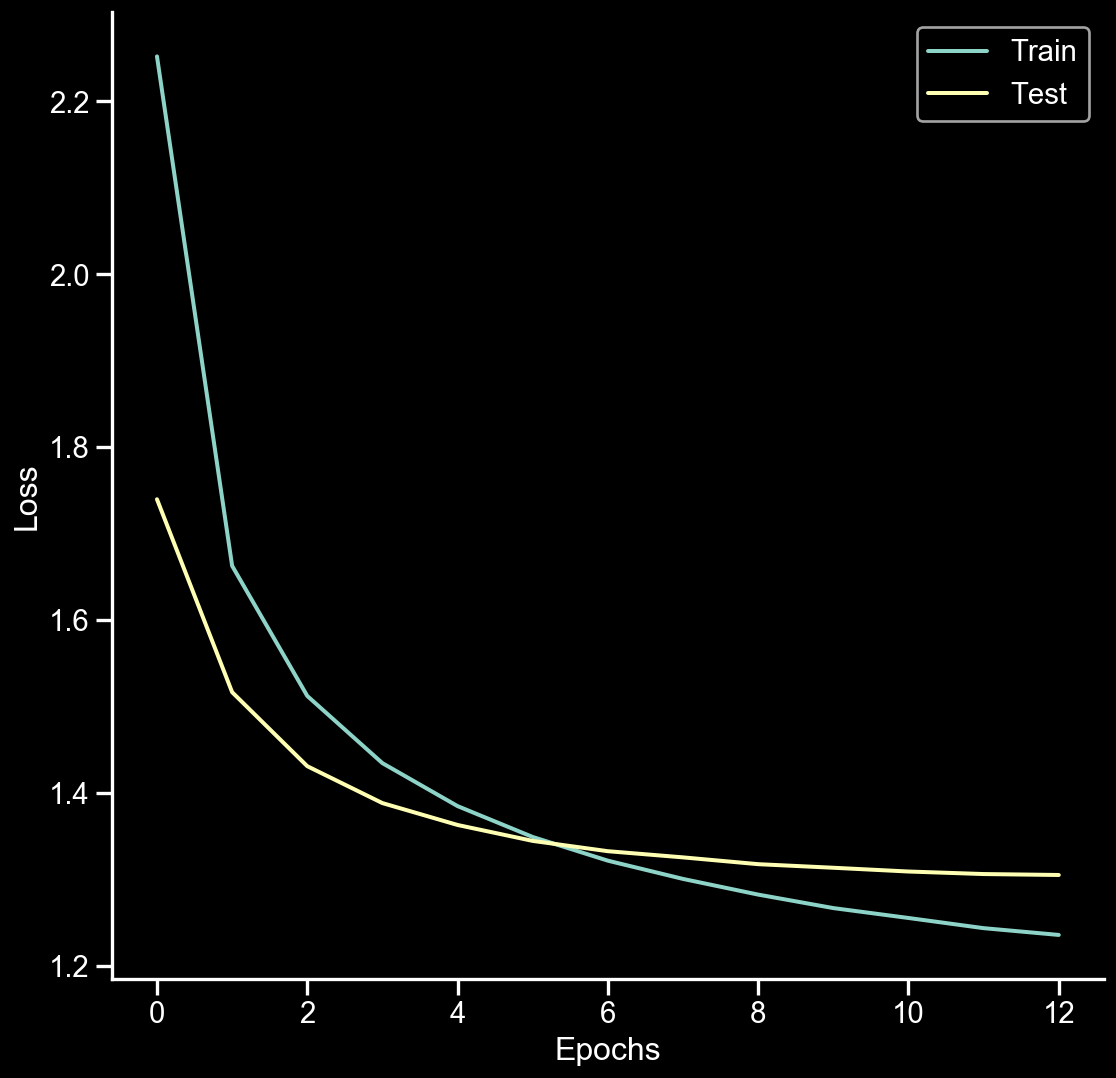

In [17]:
import numpy as np
test = np.loadtxt(test_losses_path)
train = np.loadtxt(train_losses_path)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.figure(figsize=(10,10), dpi=128)
plot1, = plt.plot(train)
plot2, = plt.plot(test)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend([plot1,plot2], ['Train', 'Test'])
# plt.yscale('log')
# plt.title('Score and Posts')
# sns.distplot(df.score)
sns.despine()
# plt.savefig('traintest.png')